<a href="https://colab.research.google.com/github/shadfdz/CCTV/blob/main/Yolo_Model_CCTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Building an Ojbect Detection Model of CCTV Frames using YoloV5 - Supervised Learning



> The CCTV_2014_10_Downstream folder contained photos of the structural anomalies found by the camera operator. The photos we're then used to build PDF reports of the condition of each manhole. The photos we're annotated using OpenLabel as described on CCTV_anomalydetection_preprocessing. In this notebook, the annotated photos are going to be used to train an object detection and classification model YoloV5 [git](https://github.com/ultralytics/yolov5).

In [ ]:
! pip install opencv-python-headless==4.1.2.30
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 14.7 MB/s 
     |████████████████████████████████| 181 kB 62.1 MB/s 
     |████████████████████████████████| 147 kB 68.0 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=132b69f33fcedffddbfcc62c13f82d7458ab65291a68dbd8865e65df1cf8e145
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import torch
import os
from IPython.display import Image, clear_output  # to display images
import cv2
import glob

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# clone yoloV5 repo
!git clone https://github.com/ultralytics/yolov5  # clone repo


Cloning into 'yolov5'...
remote: Enumerating objects: 12802, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 12802 (delta 46), reused 58 (delta 30), pack-reused 12719
Receiving objects: 100% (12802/12802), 12.40 MiB | 26.02 MiB/s, done.
Resolving deltas: 100% (8801/8801), done.


In [ ]:
# install yolo requirements
os.chdir('yolov5')
%pip install -qr requirements.txt # install dependencies

     |████████████████████████████████| 596 kB 12.7 MB/s 


### Train Test Split Images with Annotations
> Move annotated images from drive to train and test split subfolders under images and annotation folders

#### Check Instances of Each Anomaly

In [ ]:
# os.chdir(os.path.dirname(os.getcwd()))

label_list = glob.glob('content/drive/MyDrive/cctv_train_25MAY2022_labels/YOLO_darknet/*')

label_count_dict = { '0': 0,
                    '1': 0,
                    '2' : 0
}

for label in label_list:
  with open(label) as f_reader:
    annotations = f_reader.readlines()
  for line in annotations:
    if line:
      label_count_dict[line[0]] += 1

label_count_dict


{'0': 329, '1': 161, '2': 216}

#### Create subdirectory for Dataset

In [ ]:
# create sub directory for dataset in project directory
os.chdir(os.path.dirname(os.getcwd()))
os.mkdir('dataset')
os.chdir('dataset')
os.mkdir('images')
os.mkdir('labels')
os.chdir('images')
os.mkdir('train')
os.mkdir('val')
os.mkdir('test')
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))
os.chdir('dataset/labels')
os.mkdir('train')
os.mkdir('val')
os.mkdir('test')
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))

(480, 640, 3)


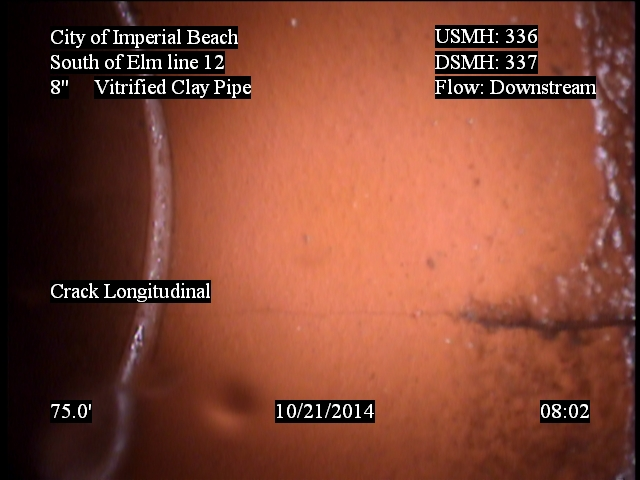

In [ ]:
# look at structure of annotatated data and propertie of image
# !ls drive/MyDrive/cctv_dataset/336_337_CL_75.0.jpg
file_path = 'drive/MyDrive/cctv_dataset/336_337_CL_75.0.jpg'
img = cv2.imread(file_path)
print(img.shape)
cv2_imshow(img)

In [ ]:
def test_train_val_split(image_f, label_f, dataset_f, val_split=0.20, seed=0):
  """
  """
  torch.manual_seed(seed)

  # get file names of images val and get sample file name list
  file_names_val = [name.replace('.jpg','') for name in os.listdir(image_f)]
  test_index = torch.randint(0,len(file_names_val),(int(len(file_names_val) * val_split),)).tolist()
  for i in test_index:
    os.system('cp ' + image_f + file_names_val[i] + '.jpg ' + dataset_f + 'images/val/')
    os.system('cp ' + label_f + file_names_val[i] + '.txt ' + dataset_f + 'labels/val/')

  # copy training samples
  for i in range(len(file_names_val)):
    if i not in test_index:
      os.system('cp ' + image_f + file_names_val[i] + '.jpg ' + dataset_f + 'images/train/')
      os.system('cp ' + label_f + file_names_val[i] + '.txt ' + dataset_f + 'labels/train/')

In [ ]:
# transfer each label category and split to train and val
image_folder_path = 'drive/MyDrive/cctv_train_25MAY2022/'
label_folder_path = 'drive/MyDrive/cctv_train_25MAY2022_labels/YOLO_darknet/'
dataset_folder_path = 'dataset/'
test_train_val_split(image_folder_path, label_folder_path, dataset_folder_path, val_split=0.1)

In [ ]:
# transfer vid frames from 2013 to test
os.system('cp -r drive/MyDrive/CCTV_Frames_2013_05_Various_p/. dataset/images/test/')
os.system('cp -r drive/MyDrive/CCTV_Frames_2013_05_Various_p_labelled/YOLO_darknet/. dataset/labels/test/')

0

In [ ]:
# create a dataset.yaml file under yolov5/data
!touch yolov5/data/dataset.yaml

Paste the following code into dataset.yaml

```
train: ../dataset/images/train/
val: ../dataset/images/val/
test: ../dataset/images/test/

# number of classes
nc: 3

# class names
names: ['root','crack','grease']
```



In [ ]:
%cat yolov5/data/dataset.yaml

train: ../dataset/images/train/
val: ../dataset/images/val/
test: ../dataset/images/test/

# number of classes
nc: 3

# class names
names: ['root','crack','grease']

In [ ]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "dataset"

## Train Models

 ### Train and Val Model with No Augmentations in Hyperparamters


In [ ]:
# train model
os.chdir('yolov5')
!python train.py --img 640 --batch 32 --epochs 300 --data 'data/dataset.yaml' --hyp 'data/hyps/hyp.custom_no_aug.yaml' --weights yolov5m.pt --cache --name '3005m_25MAY2022'

# save model
os.chdir(os.path.dirname(os.getcwd()))
!cp -r yolov5/runs/train/. drive/MyDrive/yolo_models/train/

### Train and Val Model with Low Augmentations (default)


In [ ]:
os.chdir('yolov5')
!python train.py --img 640 --batch 32 --epochs 300 --data 'data/dataset.yaml' --hyp 'data/hyps/hyp.scratch-low.yaml' --weights yolov5m.pt --cache --name '3005m_25MAY2022_low_def'

# save model
os.chdir(os.path.dirname(os.getcwd()))
!cp -r yolov5/runs/train/3005m_25MAY2022_low_def drive/MyDrive/yolo_models/train/

### Train and Val with Custom Hyp No Albumentations

In [ ]:
os.chdir('yolov5')
!python train.py --img 640 --batch 32 --epochs 300 --data 'data/dataset.yaml' --hyp 'data/hyps/hyp.custom_aug.yaml' --weights yolov5m.pt --cache --name '3005m_25MAY2022_custom'

# save model
os.chdir(os.path.dirname(os.getcwd()))
!cp -r yolov5/runs/train/3005m_25MAY2022_custom drive/MyDrive/yolo_models/train/

### Train and Val using Custom plus Albumentations (Blur)

In [ ]:
!pip install albumentations==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 6.6 MB/s 


In [ ]:
!os.chdir('yolov5')
!python train.py --img 640 --batch 32 --epochs 300 --data 'data/dataset.yaml' --hyp 'data/hyps/hyp.custom_aug.yaml' --weights yolov5m.pt --cache --name '3005m_25MAY2022_custom_album'

# save model
os.chdir(os.path.dirname(os.getcwd()))
!cp -r yolov5/runs/train/3005m_25MAY2022_custom_album drive/MyDrive/yolo_models/train/

## Validate Models

In [ ]:
# Val
!python yolov5/val.py --weights drive/MyDrive/yolo_models/train/3005m_25MAY2022_no_aug/weights/best.pt --data yolov5/data/dataset.yaml --name 3005m_25MAY2022_no_aug --task val --iou-thres=0.5
!python yolov5/val.py --weights drive/MyDrive/yolo_models/train/3005m_25MAY2022_custom_album/weights/best.pt --data yolov5/data/dataset.yaml --name 3005m_25MAY2022_custom_album --task val --iou-thres=0.5

# !cp -r yolov5/runs/val/. drive/MyDrive/yolo_models/test/

val: data=yolov5/data/dataset.yaml, weights=['drive/MyDrive/yolo_models/train/3005m_25MAY2022_no_aug/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.5, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=3005m_25MAY2022_no_aug, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-307-g92e47b8 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

Fusing layers... 
Model summary: 290 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
val: Scanning '/content/yolov5/../dataset/labels/val.cache' images and labels... 30 found, 0 missing, 4 empty, 0 corrupt: 100% 30/30 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 1/1 [00:01<00:00,  1.02s/it]
                 all         30         71      0.644      0.314      0.392      0.185
                root         30

## Test models

In [ ]:
# Test
!python yolov5/val.py --weights drive/MyDrive/yolo_models/train/3005m_25MAY2022_no_aug/weights/best.pt --data yolov5/data/dataset.yaml --name 3005m_25MAY2022_no_aug_test --task test --iou-thres=0.5
!python yolov5/val.py --weights drive/MyDrive/yolo_models/train/3005m_25MAY2022_custom_album/weights/best.pt --data yolov5/data/dataset.yaml --name 3005m_25MAY2022_custom_album_test --task test --iou-thres=0.5

!cp -r yolov5/runs/val/. drive/MyDrive/yolo_models/test/

val: data=yolov5/data/dataset.yaml, weights=['drive/MyDrive/yolo_models/train/3005m_25MAY2022_no_aug/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.5, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=3005m_25MAY2022_no_aug_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-307-g92e47b8 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

Fusing layers... 
Model summary: 290 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
test: Scanning '/content/yolov5/../dataset/labels/test.cache' images and labels... 84 found, 0 missing, 21 empty, 0 corrupt: 100% 84/84 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 3/3 [00:02<00:00,  1.26it/s]
                 all         84        182       0.45      0.245      0.302       0.12
                root  

## Train Model with Supplemental Images of Cracks

In [ ]:
# Transfer supplemental images of cracks
os.system('cp -r drive/MyDrive/cracked_processed/. dataset/images/train/')
os.system('cp -r drive/MyDrive/cracked_processed_labels/YOLO_darknet/. dataset/labels/train/')

In [ ]:
# os.chdir(os.path.dirname(os.getcwd()))

label_list = glob.glob('dataset/labels/train/*')

label_count_dict = { '0': 0,
                    '1': 0,
                    '2' : 0
}

for label in label_list:
  with open(label) as f_reader:
    annotations = f_reader.readlines()
  for line in annotations:
    if line:
      label_count_dict[line[0]] += 1

label_count_dict


{'0': 287, '1': 199, '2': 202}

In [ ]:
os.chdir('yolov5')
!python train.py --img 640 --batch 32 --epochs 300 --data 'data/dataset.yaml' --hyp 'data/hyps/hyp.custom_aug.yaml' --weights yolov5m.pt --cache --name '3005m_07JUN2022_custom'

# save model
os.chdir(os.path.dirname(os.getcwd()))
!cp -r yolov5/runs/train/3005m_07JUN2022_custom drive/MyDrive/yolo_models/train/

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
train: weights=yolov5m.pt, cfg=, data=data/dataset.yaml, hyp=data/hyps/hyp.custom_aug.yaml, epochs=300, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=3005m_07JUN2022_custom, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=Fals

In [ ]:
# test
!python yolov5/val.py --weights drive/MyDrive/yolo_models/train/3005m_07JUN2022_custom/weights/best.pt --data yolov5/data/dataset.yaml --name 3005m_07JUN2022_custom_wcrack --task test


val: data=yolov5/data/dataset.yaml, weights=['drive/MyDrive/yolo_models/train/3005m_07JUN2022_custom/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=3005m_07JUN2022_custom_wcrack, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-246-g2dd3db0 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

Fusing layers... 
Model summary: 290 layers, 20861016 parameters, 0 gradients, 48.0 GFLOPs
test: Scanning '/content/yolov5/../dataset/labels/test' images and labels...84 found, 0 missing, 21 empty, 0 corrupt: 100% 84/84 [00:00<00:00, 3180.49it/s]
test: New cache created: /content/yolov5/../dataset/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 3/3 [00:02<00:00,  1.50it/s]
                 all         84        1

## Detect Anomaly in Video using best Model

In [ ]:
model_path = 'drive/MyDrive/yolo_models/high_tta09MAY2022/weights/best.pt'
data_path = 'drive/MyDrive/CCTV_Frames_2013_05_Various'

In [ ]:
!python3 yolov5/detect.py --source 'drive/MyDrive/CCTV_Frames_2013_05_Various' --weights 'drive/MyDrive/yolo_models/low_tta09MAY2022/weights/best.pt' --conf 0.5 --iou 0.5 --name vid_test_low_tta09MAY2022
!python3 yolov5/detect.py --source 'drive/MyDrive/CCTV_Frames_2013_05_Various' --weights 'drive/MyDrive/yolo_models/med_tta09MAY2022/weights/best.pt' --conf 0.5 --iou 0.5 --name vid_test_med_tta09MAY2022
!python3 yolov5/detect.py --source 'drive/MyDrive/CCTV_Frames_2013_05_Various' --weights 'drive/MyDrive/yolo_models/high_tta09MAY2022/weights/best.pt' --conf 0.5 --iou 0.5 --name vid_test_high_tta09MAY2022

In [ ]:
!cp -r yolov5/runs/detect/. drive/MyDrive/yolo_models/detect_test/

In [ ]:
!ls drive/MyDrive/yolo_vid_test/vid_test_med_highcustom_tta09MAY2022_5L2 | head -5

MH308-MH315-08090513.wmv_270_1.jpg
MH308-MH315-08090513.wmv_270_2.jpg
MH308-MH315-08090513.wmv_271_1.jpg
MH308-MH315-08090513.wmv_271_2.jpg
MH308-MH315-08090513.wmv_272_1.jpg


In [ ]:
file_list = glob.glob('drive/MyDrive/yolo_vid_test/vid_test_med_highcustom_tta09MAY2022_5L2/*')
file_list.sort()

In [ ]:
f_path = 'drive/MyDrive/yolo_vid_test/'
f_name = 'yolo_med_high_custom_5l2'

out = cv2.VideoWriter(f_path + f_name + '.avi', cv2.VideoWriter_fourcc(*"MJPG"), 2,(640,480))
for f_name in file_list:
  img = cv2.imread(f_name)
  out.write(img)
out.release()
